In [1]:
!dir

 ドライブ D のボリューム ラベルがありません。
 ボリューム シリアル番号は 3417-05D0 です

 D:\PythonTraining\Signate\【練習問題】銀行の顧客ターゲティング のディレクトリ

2020/09/26  13:38    <DIR>          .
2020/09/26  13:38    <DIR>          ..
2020/09/26  13:36    <DIR>          .ipynb_checkpoints
2020/09/05  13:25         6,180,211 20200905_001.ipynb
2020/09/26  13:26           482,395 20200926_001.csv
2020/09/26  13:27           356,160 20200926_training1.ipynb
2020/09/26  11:40         2,591,582 mytrain.csv
2020/09/05  09:57           205,890 submit_sample.csv
2020/09/05  09:57         1,523,536 test.csv
2020/09/05  09:57         2,345,067 train.csv
2020/09/26  13:38               555 Untitled.ipynb
               8 個のファイル          13,685,396 バイト
               3 個のディレクトリ  958,166,077,440 バイトの空き領域


# Benchmark

In [7]:
# ライブラリのインポート
import pandas as pd
import lightgbm as lgb
import warnings
import gc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
warnings.simplefilter('ignore')

In [8]:
# dataの読み込み
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submit_df = pd.read_csv('submit_sample.csv',header=None)

In [9]:
# 訓練データ、テストデータがわかるようにダミーの目的変数を代入
test_df['y']=-999

In [10]:
# 訓練データ、テストデータを結合
all_df = pd.concat([train_df,test_df])
del train_df,test_df
gc.collect()

40

In [11]:
all_df

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,939,1,-1,0,unknown,1
1,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,172,10,-1,0,unknown,1
2,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,567,1,595,2,failure,1
3,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,423,1,-1,0,unknown,1
4,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,502,1,9,2,success,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18078,18079,30,management,married,tertiary,no,32,yes,no,unknown,6,may,122,3,-1,0,unknown,-999
18079,18080,35,management,married,tertiary,no,1557,yes,yes,cellular,5,feb,225,1,268,1,failure,-999
18080,18081,33,housemaid,married,primary,no,1713,yes,no,unknown,8,may,22,1,-1,0,unknown,-999
18081,18082,37,blue-collar,married,secondary,no,-251,yes,no,cellular,12,may,146,3,370,1,failure,-999


In [12]:
# カテゴリカラムの前処理
categorical_features = ['job', 'marital', 'education','default','housing','loan','contact','month','poutcome']
for col in categorical_features:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(all_df[col])
    lbl.transform(all_df[col])
    all_df[col]=lbl.transform(all_df[col])

In [13]:
all_df

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,39,1,1,1,0,1756,1,0,0,3,0,939,1,-1,0,3,1
1,2,51,2,1,0,0,1443,0,0,0,18,3,172,10,-1,0,3,1
2,3,36,4,2,2,0,436,0,0,0,13,0,567,1,595,2,0,1
3,4,63,5,1,1,0,474,0,0,0,25,4,423,1,-1,0,3,1
4,5,31,4,2,2,0,354,0,0,0,30,0,502,1,9,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18078,18079,30,4,1,2,0,32,1,0,2,6,8,122,3,-1,0,3,-999
18079,18080,35,4,1,2,0,1557,1,1,0,5,3,225,1,268,1,0,-999
18080,18081,33,3,1,0,0,1713,1,0,2,8,8,22,1,-1,0,3,-999
18081,18082,37,1,1,1,0,-251,1,0,0,12,8,146,3,370,1,0,-999


In [14]:
# 訓練データ、テストデータの分割
train_df = all_df[all_df['y']!=-999]
test_df = all_df[all_df['y']==-999]

In [15]:
y_train = train_df['y']
X_train = train_df.drop(['y','id'], axis=1)
X_test = test_df.drop(['y','id'], axis=1)

In [16]:
# 訓練データからデータを分割
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0, stratify=y_train)

In [17]:
# 使用モデルはLGB（パラメータチューニング無）
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categorical_features)

params = {
    'objective': 'binary'
}

model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=10,
    num_boost_round=1000,
    early_stopping_rounds=10
)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Info] Number of positive: 2222, number of negative: 16767
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 986
[LightGBM] [Info] Number of data points in the train set: 18989, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117015 -> initscore=-2.021005
[LightGBM] [Info] Start training from score -2.021005
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.232564	valid_1's binary_logloss: 0.237691
[20]	training's binary_logloss: 0.199925	valid_1's binary_logloss: 0.210887
[30]	training's binary_logloss: 0.184378	valid_1's binary_logloss: 0.20327
[40]	training's binary_logloss: 0.173768	valid_1's binary_logloss: 0.19966
[50]	training's binary_logloss: 0.165284	valid_1's binary_logloss: 0.197542
[6

In [18]:
y_pred

array([0.54799381, 0.53038736, 0.00069622, ..., 0.00187813, 0.00988003,
       0.00640652])

# 上位ランカー

In [19]:
output_df = pd.DataFrame()

In [21]:
org_X_train = X_train.copy()
org_y_train = y_train.copy()

In [25]:
org_X_train.shape, org_y_train.shape

((18989, 16), (18989,))

In [26]:
for i in range(100):
    # 訓練データからデータを分割
    X_train, X_valid, y_train, y_valid = train_test_split(org_X_train, org_y_train, test_size=0.3, random_state=i, stratify=org_y_train)

    # 使用モデルはLGB（パラメータチューニング無）
    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categorical_features)

    params = {
        'objective': 'binary'
    }

    model = lgb.train(
        params, lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        verbose_eval=10,
        num_boost_round=1000,
        early_stopping_rounds=10
    )

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    output_df[i] = y_pred


[LightGBM] [Info] Number of positive: 1555, number of negative: 11737
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 980
[LightGBM] [Info] Number of data points in the train set: 13292, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116988 -> initscore=-2.021271
[LightGBM] [Info] Start training from score -2.021271
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.230247	valid_1's binary_logloss: 0.243308
[20]	training's binary_logloss: 0.195441	valid_1's binary_logloss: 0.219242
[30]	training's binary_logloss: 0.177864	valid_1's binary_logloss: 0.212391
[40]	training's binary_logloss: 0.164663	valid_1's binary_logloss: 0.210063
[50]	training's binary_logloss: 0.15476	valid_1's binary_logloss: 0.20936
[6

[LightGBM] [Info] Number of positive: 1555, number of negative: 11737
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 979
[LightGBM] [Info] Number of data points in the train set: 13292, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116988 -> initscore=-2.021271
[LightGBM] [Info] Start training from score -2.021271
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.231186	valid_1's binary_logloss: 0.24392
[20]	training's binary_logloss: 0.197315	valid_1's binary_logloss: 0.219648
[30]	training's binary_logloss: 0.179299	valid_1's binary_logloss: 0.212144
[40]	training's binary_logloss: 0.166957	valid_1's binary_logloss: 0.209218
[50]	training's binary_logloss: 0.15785	valid_1's binary_logloss: 0.207312
[6

[LightGBM] [Info] Number of positive: 1555, number of negative: 11737
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 979
[LightGBM] [Info] Number of data points in the train set: 13292, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116988 -> initscore=-2.021271
[LightGBM] [Info] Start training from score -2.021271
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.230577	valid_1's binary_logloss: 0.244048
[20]	training's binary_logloss: 0.197925	valid_1's binary_logloss: 0.221128
[30]	training's binary_logloss: 0.179118	valid_1's binary_logloss: 0.213183
[40]	training's binary_logloss: 0.165602	valid_1's binary_logloss: 0.209811
[50]	training's binary_logloss: 0.155747	valid_1's binary_logloss: 0.209661


[LightGBM] [Info] Number of positive: 1555, number of negative: 11737
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 980
[LightGBM] [Info] Number of data points in the train set: 13292, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116988 -> initscore=-2.021271
[LightGBM] [Info] Start training from score -2.021271
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.228482	valid_1's binary_logloss: 0.245103
[20]	training's binary_logloss: 0.195012	valid_1's binary_logloss: 0.223834
[30]	training's binary_logloss: 0.176262	valid_1's binary_logloss: 0.216768
[40]	training's binary_logloss: 0.163273	valid_1's binary_logloss: 0.213576
[50]	training's binary_logloss: 0.15338	valid_1's binary_logloss: 0.212292
E

[LightGBM] [Info] Number of positive: 1555, number of negative: 11737
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 978
[LightGBM] [Info] Number of data points in the train set: 13292, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116988 -> initscore=-2.021271
[LightGBM] [Info] Start training from score -2.021271
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.229237	valid_1's binary_logloss: 0.244634
[20]	training's binary_logloss: 0.194269	valid_1's binary_logloss: 0.220873
[30]	training's binary_logloss: 0.175971	valid_1's binary_logloss: 0.212957
[40]	training's binary_logloss: 0.163595	valid_1's binary_logloss: 0.209837
[50]	training's binary_logloss: 0.153951	valid_1's binary_logloss: 0.208411


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116988 -> initscore=-2.021271
[LightGBM] [Info] Start training from score -2.021271
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.226689	valid_1's binary_logloss: 0.245912
[20]	training's binary_logloss: 0.191541	valid_1's binary_logloss: 0.225069
[30]	training's binary_logloss: 0.173465	valid_1's binary_logloss: 0.218859
[40]	training's binary_logloss: 0.161356	valid_1's binary_logloss: 0.216875
[50]	training's binary_logloss: 0.151947	valid_1's binary_logloss: 0.216698
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.155514	valid_1's binary_logloss: 0.21607
[LightGBM] [Info] Number of positive: 1555, number of negative: 11737
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info

[LightGBM] [Info] Number of positive: 1555, number of negative: 11737
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 979
[LightGBM] [Info] Number of data points in the train set: 13292, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116988 -> initscore=-2.021271
[LightGBM] [Info] Start training from score -2.021271
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.230468	valid_1's binary_logloss: 0.245376
[20]	training's binary_logloss: 0.195598	valid_1's binary_logloss: 0.221913
[30]	training's binary_logloss: 0.177296	valid_1's binary_logloss: 0.213193
[40]	training's binary_logloss: 0.165186	valid_1's binary_logloss: 0.210429
[50]	training's binary_logloss: 0.154843	valid_1's binary_logloss: 0.210316
Early stopping, best iteration is:
[42]	training's binary_loglos

[10]	training's binary_logloss: 0.231923	valid_1's binary_logloss: 0.242398
[20]	training's binary_logloss: 0.198456	valid_1's binary_logloss: 0.218088
[30]	training's binary_logloss: 0.179962	valid_1's binary_logloss: 0.209059
[40]	training's binary_logloss: 0.167325	valid_1's binary_logloss: 0.205342
[50]	training's binary_logloss: 0.157295	valid_1's binary_logloss: 0.204421
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.159254	valid_1's binary_logloss: 0.204252
[LightGBM] [Info] Number of positive: 1555, number of negative: 11737
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 981
[LightGBM] [Info] Number of data points in the train set: 13292, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116988 -> initscore=-2.021271
[Lig

[20]	training's binary_logloss: 0.197394	valid_1's binary_logloss: 0.218046
[30]	training's binary_logloss: 0.179802	valid_1's binary_logloss: 0.209482
[40]	training's binary_logloss: 0.166962	valid_1's binary_logloss: 0.205615
[50]	training's binary_logloss: 0.157722	valid_1's binary_logloss: 0.203778
[60]	training's binary_logloss: 0.149759	valid_1's binary_logloss: 0.203442
[70]	training's binary_logloss: 0.142589	valid_1's binary_logloss: 0.203447
Early stopping, best iteration is:
[65]	training's binary_logloss: 0.145949	valid_1's binary_logloss: 0.203023
[LightGBM] [Info] Number of positive: 1555, number of negative: 11737
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 978
[LightGBM] [Info] Number of data points in the train set: 13292, number of used features: 16
[LightGB

[20]	training's binary_logloss: 0.196905	valid_1's binary_logloss: 0.218322
[30]	training's binary_logloss: 0.178788	valid_1's binary_logloss: 0.208347
[40]	training's binary_logloss: 0.166442	valid_1's binary_logloss: 0.205216
[50]	training's binary_logloss: 0.156266	valid_1's binary_logloss: 0.203076
[60]	training's binary_logloss: 0.148323	valid_1's binary_logloss: 0.202708
Early stopping, best iteration is:
[59]	training's binary_logloss: 0.149096	valid_1's binary_logloss: 0.202688
[LightGBM] [Info] Number of positive: 1555, number of negative: 11737
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 976
[LightGBM] [Info] Number of data points in the train set: 13292, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116988 -> initscore=-2.021271
[Lig

[60]	training's binary_logloss: 0.147986	valid_1's binary_logloss: 0.208105
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.151136	valid_1's binary_logloss: 0.207605
[LightGBM] [Info] Number of positive: 1555, number of negative: 11737
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 979
[LightGBM] [Info] Number of data points in the train set: 13292, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116988 -> initscore=-2.021271
[LightGBM] [Info] Start training from score -2.021271
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.231075	valid_1's binary_logloss: 0.244718
[20]	training's binary_logloss: 0.198234	valid_1's binary_logloss: 0.221331
[30]	training's binary_logloss: 0.180728	

[69]	training's binary_logloss: 0.140205	valid_1's binary_logloss: 0.211644
[LightGBM] [Info] Number of positive: 1555, number of negative: 11737
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 980
[LightGBM] [Info] Number of data points in the train set: 13292, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116988 -> initscore=-2.021271
[LightGBM] [Info] Start training from score -2.021271
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.233244	valid_1's binary_logloss: 0.23665
[20]	training's binary_logloss: 0.200242	valid_1's binary_logloss: 0.21168
[30]	training's binary_logloss: 0.181707	valid_1's binary_logloss: 0.202848
[40]	training's binary_logloss: 0.169198	valid_1's binary_logloss: 0.199957
[5

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116988 -> initscore=-2.021271
[LightGBM] [Info] Start training from score -2.021271
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.232979	valid_1's binary_logloss: 0.237024
[20]	training's binary_logloss: 0.201075	valid_1's binary_logloss: 0.211276
[30]	training's binary_logloss: 0.182714	valid_1's binary_logloss: 0.200712
[40]	training's binary_logloss: 0.170075	valid_1's binary_logloss: 0.196774
[50]	training's binary_logloss: 0.160523	valid_1's binary_logloss: 0.195596
[60]	training's binary_logloss: 0.152613	valid_1's binary_logloss: 0.19527
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.155573	valid_1's binary_logloss: 0.19493
[LightGBM] [Info] Number of positive: 1555, number of negative: 11737
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And i

[30]	training's binary_logloss: 0.180454	valid_1's binary_logloss: 0.205139
[40]	training's binary_logloss: 0.168162	valid_1's binary_logloss: 0.201962
[50]	training's binary_logloss: 0.158004	valid_1's binary_logloss: 0.200787
[60]	training's binary_logloss: 0.150199	valid_1's binary_logloss: 0.200376
[70]	training's binary_logloss: 0.143485	valid_1's binary_logloss: 0.201301
Early stopping, best iteration is:
[60]	training's binary_logloss: 0.150199	valid_1's binary_logloss: 0.200376
[LightGBM] [Info] Number of positive: 1555, number of negative: 11737
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 979
[LightGBM] [Info] Number of data points in the train set: 13292, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116988 -> initscore=-2.021271
[Lig

In [27]:
output_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.653842,0.627558,0.629079,0.613790,0.562826,0.670790,0.469940,0.618970,0.566463,0.575187,...,0.642201,0.647986,0.620316,0.509806,0.682011,0.542413,0.665957,0.617966,0.435486,0.570155
1,0.694868,0.507771,0.541812,0.567020,0.522094,0.589407,0.581154,0.510897,0.586300,0.601613,...,0.576314,0.634916,0.624657,0.567957,0.572659,0.734023,0.584220,0.574899,0.655789,0.576540
2,0.002482,0.003061,0.001429,0.001604,0.002926,0.000968,0.000759,0.001820,0.002605,0.001560,...,0.001446,0.001227,0.001771,0.002025,0.001339,0.000814,0.001263,0.001418,0.000853,0.000339
3,0.004051,0.003310,0.001351,0.003004,0.004038,0.001817,0.001706,0.003152,0.002548,0.003006,...,0.001916,0.002073,0.001177,0.001705,0.003355,0.001865,0.003705,0.001717,0.001395,0.001618
4,0.121461,0.136177,0.148118,0.108862,0.103429,0.097691,0.137395,0.111667,0.061546,0.133966,...,0.065710,0.092515,0.051023,0.080136,0.148322,0.063383,0.110875,0.140948,0.156615,0.109539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18078,0.004162,0.003425,0.002220,0.004295,0.004689,0.001829,0.002389,0.004244,0.002894,0.004284,...,0.002754,0.003617,0.002029,0.002928,0.004889,0.002682,0.003679,0.002788,0.003393,0.002116
18079,0.071985,0.037942,0.051640,0.071142,0.085822,0.058785,0.096057,0.041395,0.059228,0.051976,...,0.044198,0.092694,0.071620,0.034818,0.044833,0.072139,0.110295,0.138452,0.031712,0.043701
18080,0.003432,0.002731,0.001609,0.001577,0.002926,0.001778,0.001499,0.002884,0.001794,0.002598,...,0.026029,0.002155,0.001787,0.001662,0.002233,0.001168,0.001815,0.001700,0.001128,0.000794
18081,0.014867,0.015454,0.004032,0.007845,0.007688,0.006956,0.004494,0.007325,0.008433,0.009850,...,0.009719,0.008601,0.009423,0.006718,0.006409,0.006017,0.007959,0.006593,0.006973,0.005955


In [28]:
output_df.mean(axis = 1)

0        0.596580
1        0.580670
2        0.001657
3        0.002715
4        0.117356
           ...   
18078    0.003313
18079    0.063521
18080    0.002406
18081    0.006934
18082    0.008054
Length: 18083, dtype: float64

In [31]:
train_df = pd.read_csv("train.csv")

In [34]:
#monthはdayと結合するつもりなので数字に直しました
#今回のデータに12月は存在しません
month_dict = {"jan":1,"feb":2,"mar":3,"apr":4,"may":5,"jun":6,"jul":7,"aug":8,"sep":9,"oct":10,"nov":11,"dec":12}
month_int = [month_dict[train_df["month"][i]] for i in range(len(train_df))]
train_df["month"] = month_int

In [35]:
train_df['month']

0        4
1        2
2        4
3        1
4        4
        ..
27123    2
27124    5
27125    5
27126    8
27127    5
Name: month, Length: 27128, dtype: int64

In [36]:
train_df['age']

0        39
1        51
2        36
3        63
4        31
         ..
27123    42
27124    34
27125    36
27126    33
27127    29
Name: age, Length: 27128, dtype: int64

<AxesSubplot:>

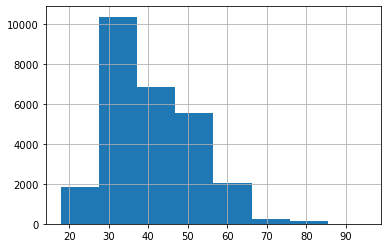

In [50]:
train_df['age'].hist(bins=8)

In [39]:
list(train_df["age"])

[39,
 51,
 36,
 63,
 31,
 29,
 37,
 32,
 31,
 32,
 35,
 34,
 34,
 31,
 38,
 71,
 62,
 66,
 46,
 29,
 28,
 67,
 42,
 33,
 39,
 57,
 43,
 46,
 31,
 36,
 33,
 52,
 30,
 41,
 29,
 56,
 48,
 30,
 60,
 32,
 31,
 29,
 33,
 31,
 39,
 23,
 51,
 39,
 40,
 69,
 32,
 30,
 56,
 32,
 49,
 45,
 45,
 55,
 77,
 30,
 56,
 54,
 32,
 43,
 48,
 50,
 50,
 35,
 39,
 36,
 30,
 43,
 37,
 53,
 45,
 30,
 53,
 45,
 51,
 35,
 53,
 33,
 49,
 36,
 41,
 36,
 34,
 37,
 47,
 54,
 46,
 36,
 47,
 34,
 38,
 35,
 38,
 42,
 29,
 56,
 46,
 34,
 56,
 60,
 25,
 29,
 37,
 33,
 35,
 46,
 35,
 34,
 31,
 39,
 32,
 37,
 41,
 39,
 28,
 34,
 34,
 32,
 70,
 30,
 52,
 51,
 41,
 39,
 44,
 58,
 34,
 38,
 30,
 48,
 58,
 34,
 31,
 37,
 57,
 28,
 32,
 32,
 39,
 41,
 47,
 28,
 26,
 60,
 49,
 32,
 25,
 25,
 57,
 50,
 39,
 34,
 38,
 30,
 28,
 31,
 32,
 28,
 35,
 48,
 30,
 46,
 40,
 37,
 54,
 26,
 52,
 67,
 33,
 42,
 56,
 35,
 38,
 33,
 30,
 35,
 45,
 28,
 58,
 58,
 27,
 39,
 40,
 37,
 58,
 60,
 48,
 45,
 38,
 29,
 39,
 43,
 33,
 32,
 62,
 49,


In [40]:
#年齢
#age
#60歳以上の扱いに悩んだので丸めました
#～59歳までは十代ごとに、60歳ちょうど、60歳より上に変換
age_list = list(train_df["age"])

new_age_list = []

for i in range(len(age_list)):
    if age_list[i] == 60:
        new_age_list.append(60)
    elif age_list[i] > 60:
        new_age_list.append(70)
    else:
        new_age_list.append(int(age_list[i]/10)*10)

train_df["age_round"] = new_age_list

In [41]:
train_df["age_round"]

0        30
1        50
2        30
3        70
4        30
         ..
27123    40
27124    30
27125    30
27126    30
27127    20
Name: age_round, Length: 27128, dtype: int64

In [44]:
def age_round(x):
    if x == 60:
        return 60
    elif x > 60:
        return 70
    else:
        return int(x/10)*10

In [45]:
train_df['age_round2'] = train_df['age'].apply(age_round)
train_df['age_round2']

0        30
1        50
2        30
3        70
4        30
         ..
27123    40
27124    30
27125    30
27126    30
27127    20
Name: age_round2, Length: 27128, dtype: int64

In [48]:
train_df.describe()

,id,age,balance,day,month,duration,campaign,pdays,previous,y,age_round,age_round2
count,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000
mean,13564.500000,40.951010,1355.800870,15.806215,6.132262,260.711295,2.751769,40.528052,0.579733,0.117001,36.584710,36.584710
std,7831.323388,10.608542,3003.305272,8.337904,2.402256,260.091727,3.126594,100.382462,2.503653,0.321427,11.076654,11.076654
min,1.000000,18.000000,-6847.000000,1.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,10.000000,10.000000
25%,6782.750000,33.000000,72.000000,8.000000,5.000000,104.000000,1.000000,-1.000000,0.000000,0.000000,30.000000,30.000000
50%,13564.500000,39.000000,449.000000,16.000000,6.000000,182.000000,2.000000,-1.000000,0.000000,0.000000,30.000000,30.000000
75%,20346.250000,48.000000,1428.000000,21.000000,8.000000,323.000000,3.000000,-1.000000,0.000000,0.000000,40.000000,40.000000
max,27128.000000,95.000000,102127.000000,31.000000,12.000000,4918.000000,63.000000,871.000000,275.000000,1.000000,70.000000,70.000000


<AxesSubplot:>

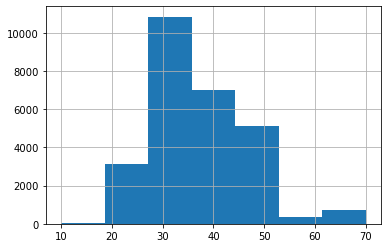

In [49]:
train_df['age_round2'].hist(bins=7)

In [51]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27128 entries, 0 to 27127
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          27128 non-null  int64 
 1   age         27128 non-null  int64 
 2   job         27128 non-null  object
 3   marital     27128 non-null  object
 4   education   27128 non-null  object
 5   default     27128 non-null  object
 6   balance     27128 non-null  int64 
 7   housing     27128 non-null  object
 8   loan        27128 non-null  object
 9   contact     27128 non-null  object
 10  day         27128 non-null  int64 
 11  month       27128 non-null  int64 
 12  duration    27128 non-null  int64 
 13  campaign    27128 non-null  int64 
 14  pdays       27128 non-null  int64 
 15  previous    27128 non-null  int64 
 16  poutcome    27128 non-null  object
 17  y           27128 non-null  int64 
 18  age_round   27128 non-null  int64 
 19  age_round2  27128 non-null  int64 
dtypes: int

In [52]:
numeric_col_list = ["age","balance","duration","campaign","pdays","previous"]

In [53]:
categorical_col_list  = [categorical_feature for categorical_feature in train_df.columns if categorical_feature not in numeric_col_list]
categorical_col_list.remove("id")

In [54]:
categorical_col_list

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'poutcome',
 'y',
 'age_round',
 'age_round2']

In [61]:
train_df.select_dtypes(exclude='object').columns.tolist()

['id',
 'age',
 'balance',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'y',
 'age_round',
 'age_round2']

In [65]:
#numericについては目的変数でグルーピングして統計量を算出
for target_col in numeric_col_list:
    print("\ntarget_col：",target_col)
    display(train_df.groupby("y")[target_col].describe())


target_col： age


,count,mean,std,min,25%,50%,75%,max
y,,,,,,,,
0,23954.0,40.870335,10.175948,18.0,33.0,39.0,48.0,95.0
1,3174.0,41.559861,13.417584,18.0,31.0,38.0,50.0,93.0



target_col： balance


,count,mean,std,min,25%,50%,75%,max
y,,,,,,,,
0,23954.0,1305.702805,2996.408734,-6847.0,58.0,417.0,1344.00,102127.0
1,3174.0,1733.888154,3028.712596,-3058.0,215.0,718.5,2148.25,52587.0



target_col： duration


,count,mean,std,min,25%,50%,75%,max
y,,,,,,,,
0,23954.0,222.709861,207.103447,0.0,96.00,165.0,281.0,4918.0
1,3174.0,547.505986,401.711459,8.0,247.25,434.5,731.0,3102.0



target_col： campaign


,count,mean,std,min,25%,50%,75%,max
y,,,,,,,,
0,23954.0,2.838399,3.251450,1.0,1.0,2.0,3.0,63.0
1,3174.0,2.097984,1.811868,1.0,1.0,2.0,2.0,24.0



target_col： pdays


,count,mean,std,min,25%,50%,75%,max
y,,,,,,,,
0,23954.0,36.840110,97.375842,-1.0,-1.0,-1.0,-1.00,871.0
1,3174.0,68.360744,117.007492,-1.0,-1.0,-1.0,98.75,805.0



target_col： previous


,count,mean,std,min,25%,50%,75%,max
y,,,,,,,,
0,23954.0,0.50334,2.494818,0.0,0.0,0.0,0.0,275.0
1,3174.0,1.15627,2.495410,0.0,0.0,0.0,1.0,55.0


In [63]:
#categoricalについては目的変数でグルーピングしてカウント
for target_col in categorical_col_list:
    print("\ntarget_col：",target_col)
    display(train_df.groupby(["y",target_col])[target_col].count())


target_col： job


y  job          
0  admin.           2700
   blue-collar      5456
   entrepreneur      834
   housemaid         697
   management       4853
   retired          1080
   self-employed     828
   services         2282
   student           391
   technician       4013
   unemployed        660
   unknown           160
1  admin.            385
   blue-collar       430
   entrepreneur       80
   housemaid          68
   management        767
   retired           311
   self-employed     117
   services          224
   student           166
   technician        478
   unemployed        130
   unknown            18
Name: job, dtype: int64


target_col： marital


y  marital 
0  divorced     2691
   married     14744
   single       6519
1  divorced      364
   married      1667
   single       1143
Name: marital, dtype: int64


target_col： education


y  education
0  primary       3798
   secondary    12382
   tertiary      6790
   unknown        984
1  primary        352
   secondary     1500
   tertiary      1169
   unknown        153
Name: education, dtype: int64


target_col： default


y  default
0  no         23507
   yes          447
1  no          3137
   yes           37
Name: default, dtype: int64


target_col： housing


y  housing
0  no          9991
   yes        13963
1  no          2012
   yes         1162
Name: housing, dtype: int64


target_col： loan


y  loan
0  no      19912
   yes      4042
1  no       2876
   yes       298
Name: loan, dtype: int64


target_col： contact


y  contact  
0  cellular     14951
   telephone     1457
   unknown       7546
1  cellular      2629
   telephone      230
   unknown        315
Name: contact, dtype: int64


target_col： day


y  day
0  1      138
   2      675
   3      557
   4      739
   5      997
         ... 
1  27      83
   28      81
   29      73
   30     166
   31      28
Name: day, Length: 62, dtype: int64


target_col： month


y  month
0  1         762
   2        1328
   3         147
   4        1418
   5        7751
   6        2880
   7        3760
   8        3293
   9         195
   10        247
   11       2107
   12         66
1  1          84
   2         258
   3         152
   4         337
   5         566
   6         324
   7         376
   8         425
   9         161
   10        192
   11        235
   12         64
Name: month, dtype: int64


target_col： poutcome


y  poutcome
0  failure      2578
   other         950
   success       312
   unknown     20114
1  failure       391
   other         173
   success       574
   unknown      2036
Name: poutcome, dtype: int64


target_col： y


y  y
0  0    23954
1  1     3174
Name: y, dtype: int64


target_col： age_round


y  age_round
0  10             21
   20           2585
   30           9674
   40           6347
   50           4636
   60            283
   70            408
1  10             11
   20            537
   30           1162
   40            637
   50            466
   60             64
   70            297
Name: age_round, dtype: int64


target_col： age_round2


y  age_round2
0  10              21
   20            2585
   30            9674
   40            6347
   50            4636
   60             283
   70             408
1  10              11
   20             537
   30            1162
   40             637
   50             466
   60              64
   70             297
Name: age_round2, dtype: int64

In [74]:
pd.crosstab(train_df['y'], train_df['housing'], margins=True, normalize='columns')

housing,no,yes,All
y,,,
0,0.832375,0.923174,0.882999
1,0.167625,0.076826,0.117001


In [75]:
#平均値と中央値を可視化して確認
#yの01別で平均値、中央値
y0_df = train_df.query('y == 0')
y1_df = train_df.query('y == 1')

In [78]:
y0_df2 = train_df[train_df['y'] == 0]
y1_df2 = train_df[train_df['y'] == 1]


In [79]:
y0_df

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_round,age_round2
19,20,29,admin.,single,tertiary,no,89,yes,no,cellular,22,7,120,1,-1,0,unknown,0,20,20
20,21,28,self-employed,married,tertiary,no,112,yes,yes,cellular,5,5,145,1,-1,0,unknown,0,20,20
21,22,67,retired,married,primary,no,708,no,no,cellular,11,9,96,2,-1,0,unknown,0,70,70
23,24,33,admin.,divorced,secondary,no,420,yes,no,telephone,6,2,112,2,-1,0,unknown,0,30,30
24,25,39,services,single,secondary,no,158,yes,no,unknown,6,6,354,2,-1,0,unknown,0,30,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27123,27124,42,blue-collar,married,primary,no,1455,yes,no,cellular,2,2,279,2,269,2,other,0,40,40
27124,27125,34,services,single,secondary,no,719,yes,no,unknown,15,5,362,3,-1,0,unknown,0,30,30
27125,27126,36,blue-collar,single,primary,no,49,yes,no,unknown,8,5,405,1,-1,0,unknown,0,30,30
27126,27127,33,housemaid,married,primary,no,209,no,no,cellular,12,8,76,4,-1,0,unknown,0,30,30


In [80]:
y0_df2

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_round,age_round2
19,20,29,admin.,single,tertiary,no,89,yes,no,cellular,22,7,120,1,-1,0,unknown,0,20,20
20,21,28,self-employed,married,tertiary,no,112,yes,yes,cellular,5,5,145,1,-1,0,unknown,0,20,20
21,22,67,retired,married,primary,no,708,no,no,cellular,11,9,96,2,-1,0,unknown,0,70,70
23,24,33,admin.,divorced,secondary,no,420,yes,no,telephone,6,2,112,2,-1,0,unknown,0,30,30
24,25,39,services,single,secondary,no,158,yes,no,unknown,6,6,354,2,-1,0,unknown,0,30,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27123,27124,42,blue-collar,married,primary,no,1455,yes,no,cellular,2,2,279,2,269,2,other,0,40,40
27124,27125,34,services,single,secondary,no,719,yes,no,unknown,15,5,362,3,-1,0,unknown,0,30,30
27125,27126,36,blue-collar,single,primary,no,49,yes,no,unknown,8,5,405,1,-1,0,unknown,0,30,30
27126,27127,33,housemaid,married,primary,no,209,no,no,cellular,12,8,76,4,-1,0,unknown,0,30,30


In [82]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows' ,500)
pd.set_option('display.max_columns', 100)

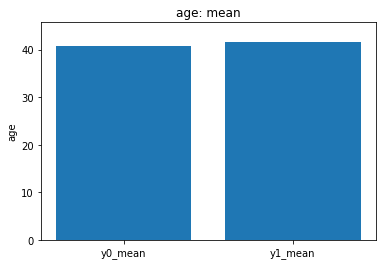

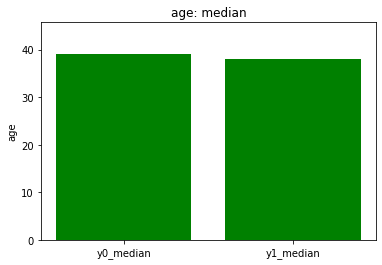

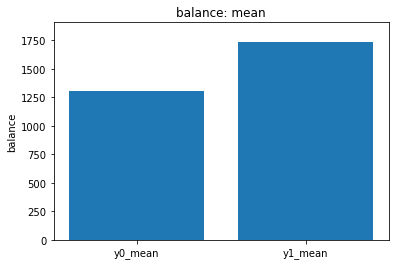

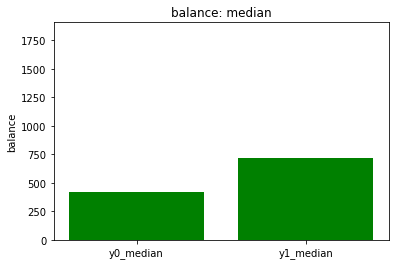

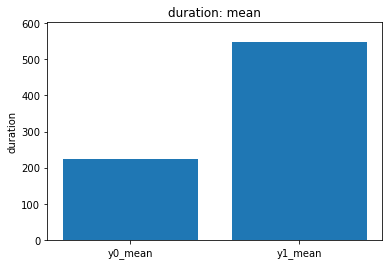

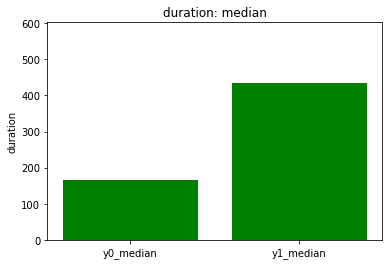

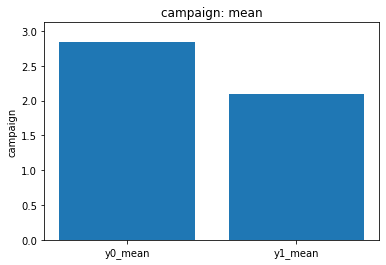

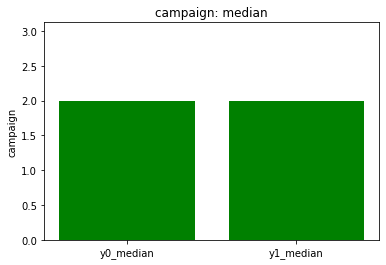

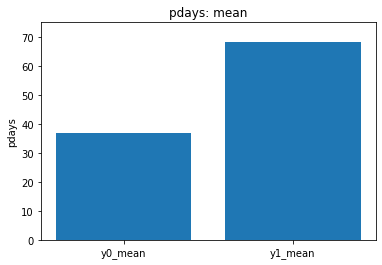

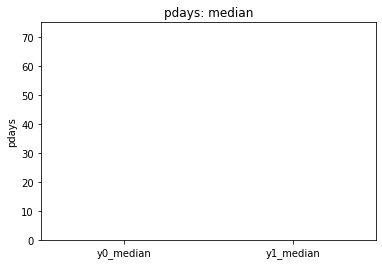

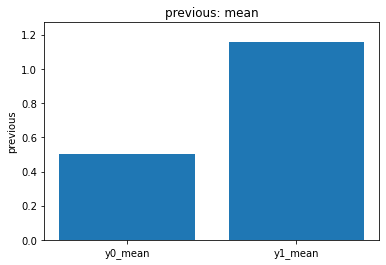

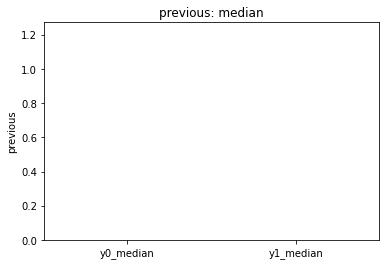

In [83]:
for target_col in numeric_col_list:

    #0,1別平均値
    y0_target_col_mean = y0_df[target_col].mean()
    y1_target_col_mean = y1_df[target_col].mean()

    #0,1別中央値
    y0_target_col_median = y0_df[target_col].median()
    y1_target_col_median = y1_df[target_col].median()

    #縦軸設定
    #平均値、中央値のうち最大値の1.1倍を縦軸とする
    #倍率は見やすければ何でもよい
    graph_y_length = (1.1*max(y0_target_col_mean,y1_target_col_mean,y0_target_col_median,y1_target_col_median))

    plt.title(target_col + ": mean")
    plt.ylabel(target_col)
    plt.ylim([0,graph_y_length],)
    plt.bar(["y0_mean","y1_mean"],[y0_target_col_mean,y1_target_col_mean])
    #plt.annotate(y0_target_col_mean,y0_target_col_mean)
    plt.show()

    plt.title(target_col + ": median")
    plt.ylabel(target_col)
    plt.ylim([0,graph_y_length],)
    plt.bar(["y0_median","y1_median"],[y0_target_col_median,y1_target_col_median],color = "green")
    plt.show()

y0 age
y1 age


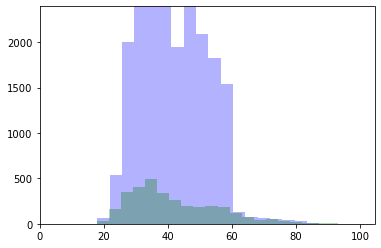

y0 balance
y1 balance


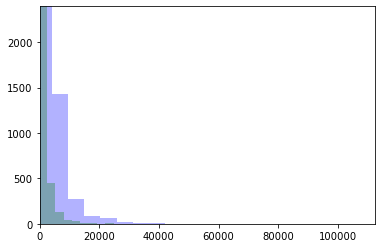

y0 duration
y1 duration


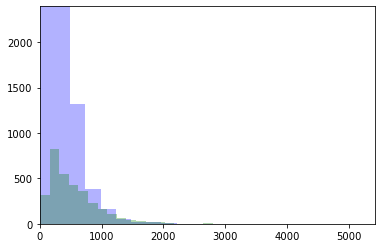

y0 campaign
y1 campaign


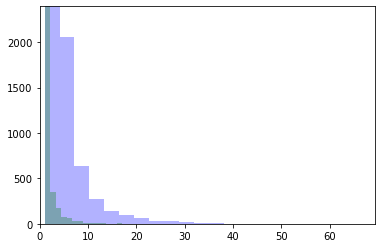

y0 pdays
y1 pdays


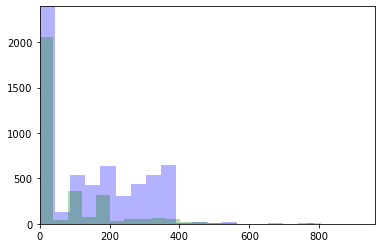

y0 previous
y1 previous


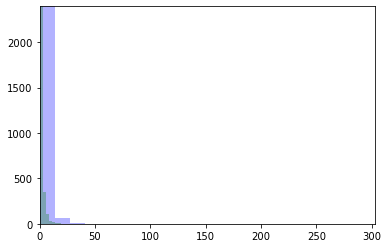

In [88]:
#ヒストグラムでも全体像把握
for target_col in numeric_col_list:
    #軸の設定
    graph_x_length = 1.1*max(train_df[target_col])
    graph_y_length = len(y0_df)

    print("y0",target_col)
    plt.xlim([0,graph_x_length],)
    plt.ylim([0,graph_y_length],)
    plt.hist(y0_df[target_col],bins = 20, alpha=0.3, color='blue')
#     plt.show()

    graph_y_length = graph_y_length/10
    print("y1",target_col)
    plt.xlim([0,graph_x_length],)
    plt.ylim([0,graph_y_length],)
    plt.hist(y1_df[target_col],bins = 20, alpha=0.3, color='green')
    plt.show()

In [89]:
#相関係数算出
train_df.corr()

,id,age,balance,day,month,duration,campaign,pdays,previous,y,age_round,age_round2
id,1.000000,-0.005716,-0.000484,0.002974,0.001007,0.002705,0.016867,-0.004526,-0.005425,-0.003555,-0.006858,-0.006858
age,-0.005716,1.000000,0.095343,-0.008518,0.091014,-0.005309,-0.001340,-0.025272,0.002946,0.020892,0.958293,0.958293
balance,-0.000484,0.095343,1.000000,0.002067,0.094794,0.019923,-0.016295,0.003613,0.012483,0.045826,0.095728,0.095728
day,0.002974,-0.008518,0.002067,1.000000,0.098321,-0.032453,0.164880,-0.096889,-0.050009,-0.031058,-0.006763,-0.006763
month,0.001007,0.091014,0.094794,0.098321,1.000000,-0.014608,0.057231,-0.113627,-0.038063,0.022353,0.098894,0.098894
duration,0.002705,-0.005309,0.019923,-0.032453,-0.014608,1.000000,-0.087771,0.002030,0.002489,0.401390,-0.002985,-0.002985
campaign,0.016867,-0.001340,-0.016295,0.164880,0.057231,-0.087771,1.000000,-0.086220,-0.031557,-0.076118,-0.001201,-0.001201
pdays,-0.004526,-0.025272,0.003613,-0.096889,-0.113627,0.002030,-0.086220,1.000000,0.421606,0.100930,-0.020755,-0.020755
previous,-0.005425,0.002946,0.012483,-0.050009,-0.038063,0.002489,-0.031557,0.421606,1.000000,0.083825,0.006822,0.006822
y,-0.003555,0.020892,0.045826,-0.031058,0.022353,0.401390,-0.076118,0.100930,0.083825,1.000000,0.031063,0.031063


In [90]:
#目的変数の相関係数だけピックアップ
train_df.corr()["y"]

id           -0.003555
age           0.020892
balance       0.045826
day          -0.031058
month         0.022353
duration      0.401390
campaign     -0.076118
pdays         0.100930
previous      0.083825
y             1.000000
age_round     0.031063
age_round2    0.031063
Name: y, dtype: float64